## Dow Jones Index Trading Signal Prediction
### Data Analyse and Preprocessing

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib, pandas as pd, numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

# fetch dataset
dow_jones_index = fetch_ucirepo(id=312)

# data (as pandas dataframes)
print(dow_jones_index.data.features)
print("\n----\n")
print(dow_jones_index.data.targets)
print(dow_jones_index.variables)

df = pd.concat([dow_jones_index.data.features, dow_jones_index.data.targets], axis=1)
df.info()
df['stock'].describe()

     quarter stock       date    open    high     low   close     volume  \
0          1    AA   1/7/2011  $15.82  $16.72  $15.78  $16.42  239655616   
1          1    AA  1/14/2011  $16.71  $16.71  $15.64  $15.97  242963398   
2          1    AA  1/21/2011  $16.19  $16.38  $15.60  $15.79  138428495   
3          1    AA  1/28/2011  $15.87  $16.63  $15.82  $16.13  151379173   
4          1    AA   2/4/2011  $16.18  $17.39  $16.18  $17.14  154387761   
..       ...   ...        ...     ...     ...     ...     ...        ...   
745        2   XOM  5/27/2011  $80.22  $82.63  $80.07  $82.63   68230855   
746        2   XOM   6/3/2011  $83.28  $83.75  $80.18  $81.18   78616295   
747        2   XOM  6/10/2011  $80.93  $81.87  $79.72  $79.78   92380844   
748        2   XOM  6/17/2011  $80.00  $80.82  $78.33  $79.02  100521400   
749        2   XOM  6/24/2011  $78.65  $81.12  $76.78  $76.78  118679791   

     percent_change_price  percent_change_volume_over_last_wk  \
0                 3.79

count     750
unique     30
top        AA
freq       25
Name: stock, dtype: object

In [271]:
# Preprocessing
df['date'] = pd.to_datetime(df['date'])
# Remove irrelevant char
for c in ['open', 'high', 'low', 'close', 'volume']:
    if c in df.columns:
        df[c] = df[c].replace('[\$,]', '', regex=True).astype(float)
        
# Missing value
df['percent_change_volume_over_last_wk'] = df['percent_change_volume_over_last_wk'].fillna(0)
df['previous_weeks_volume'] = df['previous_weeks_volume'].fillna(0)


### Feature Enginnerring
- Constructing technical indicators that often use in analysing stock market

In [272]:
import pandas as pd
import numpy as np
import talib

def generate_features(df):
    df = df.copy()

    def construct_and_fill(group):
        group = group.copy()

        # ===== Construct technical indicators =====
        group['ema_2'] = talib.EMA(group['close'], timeperiod=2)
        group['ema_4'] = talib.EMA(group['close'], timeperiod=4)
        group['ema_diff'] = group['ema_2'] - group['ema_4']
        group['rsi_2'] = talib.RSI(group['close'], timeperiod=2)
        group['atr_3'] = talib.ATR(group['high'], group['low'], group['close'], timeperiod=3)
        macd, macdsignal, macdhist = talib.MACD(group['close'], fastperiod=2, slowperiod=5, signalperiod=2)
        group['macd'] = macd
        group['macd_signal'] = macdsignal
        group['macd_hist'] = macdhist
        group['momentum_1'] = group['close'].pct_change(periods=1)
        group['momentum_3'] = group['close'].pct_change(periods=3)
        group['roc_2'] = talib.ROC(group['close'], timeperiod=2)
        group['volatility_3'] = group['percent_change_price'].rolling(3).std()
        group['vpt'] = (group['percent_change_price'] * group['volume']).cumsum()
        group['price_volume_ratio'] = group['percent_change_price'] / (group['percent_change_volume_over_last_wk'] + 1e-6)

        # ===== Fill missing values =====
        indicator_cols = [
            'ema_2', 'ema_4', 'ema_diff',
            'rsi_2', 'atr_3',
            'macd', 'macd_signal', 'macd_hist',
            'momentum_1', 'momentum_3', 'roc_2',
            'volatility_3','vpt', 'price_volume_ratio'
        ]
        
        # Remove Feature
        del group['previous_weeks_volume']

        # Forward fill
        group[indicator_cols] = group[indicator_cols].ffill()

        # Fill remaining NaNs with mean values
        for col in indicator_cols:
            group[col] = group[col].fillna(group[col].mean())

        # Set momentums as 0 if still NaN
        group[['momentum_1', 'momentum_3']] = group[['momentum_1', 'momentum_3']].fillna(0)

        # Fill any final NaNs
        group[indicator_cols] = group[indicator_cols].fillna(0)

        return group

    # Apply by stock
    df = df.groupby('stock').apply(construct_and_fill).reset_index(drop=True)

    return df

In [273]:
df_features = generate_features(df)  # df is original dataset which contains every data and attributes

df_features['percent_change_price'].describe()

C:\Users\22519\AppData\Local\Temp\ipykernel_5096\48255174.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('stock').apply(construct_and_fill).reset_index(drop=True)


count    750.000000
mean       0.050262
std        2.517809
min      -15.422900
25%       -1.288053
50%        0.000000
75%        1.650888
max        9.882230
Name: percent_change_price, dtype: float64

### Analyse `percent_change_price` distribution to decide the threshold
- It's a foundation for data analayst or manager to decide how to set threshold
- Here we decide to use 25% and 75% as our threshold, hence constructing bondary of BUY,HOLD and SELL signal

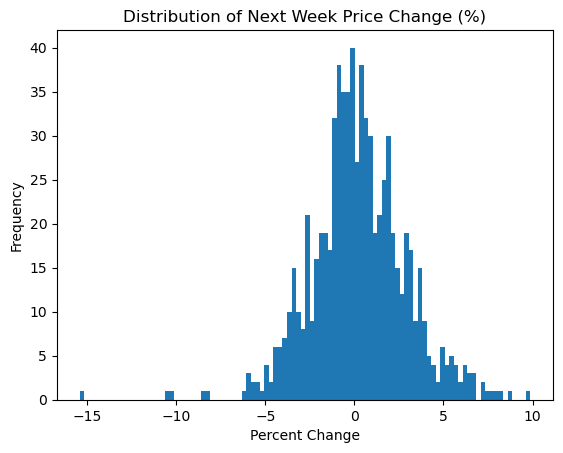

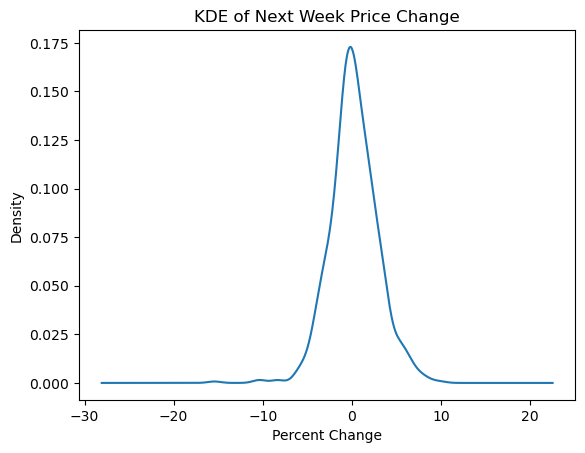

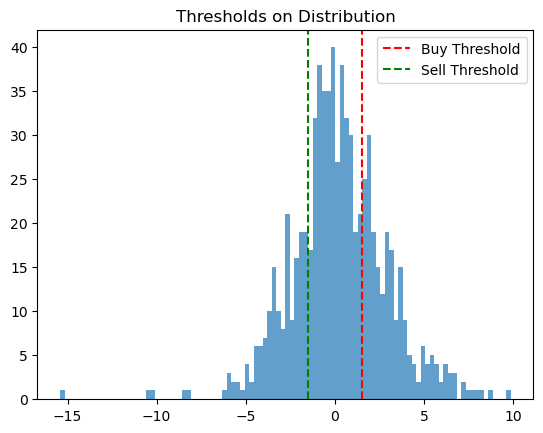

In [274]:
df_features["percent_change_price"].describe()
plt.hist(df_features['percent_change_next_weeks_price'], bins=100)
plt.title('Distribution of Next Week Price Change (%)')
plt.xlabel('Percent Change')
plt.ylabel('Frequency')
plt.show()

df['percent_change_next_weeks_price'].plot(kind='kde')
plt.title('KDE of Next Week Price Change')
plt.xlabel('Percent Change')
plt.show()



threshold_up = 1.5
threshold_down = -1.5

plt.hist(df['percent_change_next_weeks_price'], bins=100, alpha=0.7)
plt.axvline(threshold_up, color='red', linestyle='--', label='Buy Threshold')
plt.axvline(threshold_down, color='green', linestyle='--', label='Sell Threshold')
plt.legend()
plt.title('Thresholds on Distribution')
plt.show()


### Model Trainning

In [275]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

class BaseSignalModel:
    def __init__(self, model, feature_cols=None, threshold=2, name=None, risk_free_rate=0.02, train_ratio=0.8):
        self.model = model
        self.name = name or model.__class__.__name__
        self.scaler = StandardScaler()
        self.threshold = threshold
        self.feature_cols = feature_cols
        self.risk_free_rate = risk_free_rate
        self.metrics = {}
        self.support_cv = True
        self.train_ratio = train_ratio

    def fit(self, df, cv_splits=None):
        df = df.copy()

        if self.feature_cols is None:
            self.feature_cols = [col for col in df.columns if col not in [
                'stock', 'date', 'percent_change_next_weeks_price', 
                'next_weeks_open', 'next_weeks_close'
            ]]

        df = df.sort_values(by=['stock', 'date']).reset_index(drop=True)

        # 切分 train/test
        train_list = []
        test_list = []

        for stock in df['stock'].unique():
            stock_data = df[df['stock'] == stock]
            n_train = int(len(stock_data) * self.train_ratio)
            train_data = stock_data.iloc[:n_train]
            test_data = stock_data.iloc[n_train:]
            train_list.append(train_data)
            test_list.append(test_data)

        train_df = pd.concat(train_list).reset_index(drop=True)
        test_df = pd.concat(test_list).reset_index(drop=True)

        # 特征和标签
        X_train = train_df[self.feature_cols]
        y_train = train_df['percent_change_next_weeks_price']

        X_test = test_df[self.feature_cols]
        y_test = test_df['percent_change_next_weeks_price']

        # 特征缩放
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # ====== 交叉验证 (在训练集内部) ======
        if cv_splits is not None and cv_splits >= 2:
            tscv = TimeSeriesSplit(n_splits=cv_splits)

            cv_rmse = []
            cv_mae = []
            cv_r2 = []

            for train_index, val_index in tscv.split(X_train_scaled):
                X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
                y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

                model_clone = self._clone_model()  # 保证每一折使用新的模型
                model_clone.fit(X_tr, y_tr)
                y_val_pred = model_clone.predict(X_val)

                cv_rmse.append(root_mean_squared_error(y_val, y_val_pred))
                cv_mae.append(mean_absolute_error(y_val, y_val_pred))
                cv_r2.append(r2_score(y_val, y_val_pred))

            self.metrics['CV_RMSE'] = np.mean(cv_rmse)
            self.metrics['CV_MAE'] = np.mean(cv_mae)
            self.metrics['CV_R2'] = np.mean(cv_r2)

        # ====== 在完整训练集上训练，然后在测试集上评估 ======
        self.model.fit(X_train_scaled, y_train)
        y_pred = self.model.predict(X_test_scaled)

        self.metrics['RMSE'] = root_mean_squared_error(y_test, y_pred)
        self.metrics['MAE'] = mean_absolute_error(y_test, y_pred)
        self.metrics['R2'] = r2_score(y_test, y_pred)

        # 方向准确率
        pred_direction = np.where(y_pred > self.threshold, 1, np.where(y_pred < -self.threshold, -1, 0))
        true_direction = np.where(y_test > self.threshold, 1, np.where(y_test < -self.threshold, -1, 0))
        self.metrics['Direction_Accuracy'] = np.mean(pred_direction == true_direction)

    def _clone_model(self):
        """克隆基础模型，防止在交叉验证中污染原模型"""
        from sklearn.base import clone
        return clone(self.model)

    def predict(self, df):
        df = df.copy()
        X_scaled = self.scaler.transform(df[self.feature_cols])
        df['predicted_return'] = self.model.predict(X_scaled)
        return df

    def generate_signal(self, df, threshold=None):
        threshold = threshold if threshold is not None else self.threshold
        df = df.copy()
        df['signal'] = 0
        df.loc[df['predicted_return'] > threshold, 'signal'] = 1
        df.loc[df['predicted_return'] < -threshold, 'signal'] = -1
        return df

    def backtest(self, df):
        df = df.copy()
        df['percent_change_next_weeks_price'] = df['percent_change_next_weeks_price'] / 100
        df['strategy_return'] = df['signal'] * df['percent_change_next_weeks_price']
        df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
        df['cumulative_market_return'] = (1 + df['percent_change_next_weeks_price']).cumprod()

        returns = df['strategy_return']
        periods_per_year = 52  # weekly

        cagr = (df['cumulative_strategy_return'].iloc[-1])**(1/ (len(df)/periods_per_year)) - 1
        max_drawdown = self._calculate_max_drawdown(df['cumulative_strategy_return'])
        sharpe = (returns.mean() * periods_per_year - self.risk_free_rate) / (returns.std() * np.sqrt(periods_per_year))

        self.metrics['CAGR'] = cagr
        self.metrics['Max_Drawdown'] = max_drawdown
        self.metrics['Sharpe_Ratio'] = sharpe
        return df

    @staticmethod
    def _calculate_max_drawdown(cumulative_returns):
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        return max_drawdown



In [276]:
class BaselineModel:
    def __init__(self, mode='naive', name=None,threshold = 2):
        assert mode in ['naive', 'zero'], "the model either be'naive' or 'zero'"
        self.mode = mode
        self.name = name or f"Baseline-{mode.capitalize()}"
        self.metrics = {}
        self.threshold = threshold

    def fit(self, df):
        df = df.copy()
        self.df_train = df

    def predict(self, df):
        df = df.copy()
        # Use current week data to predict next week, which means gussing
        if self.mode == 'naive':
            df['predicted_return'] = df['percent_change_price']
        # Always predict 0
        elif self.mode == 'zero':
            df['predicted_return'] = 0.0
        return df

    def generate_signal(self, df):
        df = df.copy()
        df['signal'] = 0
        df.loc[df['predicted_return'] > self.threshold, 'signal'] = 1
        df.loc[df['predicted_return'] < -self.threshold, 'signal'] = -1
        return df

    def evaluate(self, df):
        y_true = df['percent_change_next_weeks_price']
        y_pred = df['predicted_return']

        self.metrics['RMSE'] = root_mean_squared_error(y_true, y_pred)
        self.metrics['MAE'] = mean_absolute_error(y_true, y_pred)
        self.metrics['R2'] = r2_score(y_true, y_pred)
        # Direction Accuracy Test(signal:Buy,Sell,Hold)
        pred_direction = np.where(y_pred > self.threshold, 1, np.where(y_pred < -self.threshold, -1, 0))
        true_direction = np.where(y_true > self.threshold, 1, np.where(y_true < -self.threshold, -1, 0))
        self.metrics['Direction_Accuracy'] = np.mean(pred_direction == true_direction)


    def backtest(self, df):
        df = df.copy()
        df['percent_change_next_weeks_price'] = df['percent_change_next_weeks_price'] / 100
        df['strategy_return'] = df['signal'] * df['percent_change_next_weeks_price']
        df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
        df['cumulative_market_return'] = (1 + df['percent_change_next_weeks_price']).cumprod()

        returns = df['strategy_return']
        periods_per_year = 52

        cagr = (df['cumulative_strategy_return'].iloc[-1])**(1/ (len(df)/periods_per_year)) - 1
        max_drawdown = self._calculate_max_drawdown(df['cumulative_strategy_return'])
        sharpe = (returns.mean() * periods_per_year - 0.02) / (returns.std() * np.sqrt(periods_per_year))

        self.metrics['CAGR'] = cagr
        self.metrics['Max_Drawdown'] = max_drawdown
        self.metrics['Sharpe_Ratio'] = sharpe

        self.evaluate(df)
        return df

    @staticmethod
    def _calculate_max_drawdown(cumulative_returns):
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        return max_drawdown


In [277]:
class Runner:
    def __init__(self, models, cv_splits=None):
        """
        models: dict, e.g., {"naive": BaselineModel(), "my_model": BaseSignalModel(model)}
        cv_splits: int or None, number of splits for TimeSeries CV
        """
        self.models = models
        self.results = {}
        self.cv_splits = cv_splits

    def run(self, df):
        """
        Train, test, generate signal, evaluate all models
        """
        for name, model in self.models.items():
            #model.fit(df, cv_splits=self.cv_splits)
            if getattr(model, 'support_cv', False):
                model.fit(df, cv_splits=self.cv_splits)
            else:
                model.fit(df)

            df_pred = model.predict(df)
            df_pred = model.generate_signal(df_pred)

            if hasattr(model, 'evaluate'):
                model.evaluate(df_pred)
            if hasattr(model, 'backtest'):
                model.backtest(df_pred)

            self.results[name] = model.metrics

    def summary(self):
        """
        Compare all models
        """
        summary_df = pd.DataFrame(self.results).T
        summary_df = summary_df.sort_values(by='Sharpe_Ratio', ascending=False)
        return summary_df



### Run and Test

In [278]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

# 1. Feature Engineering
df_feat = generate_features(df)

# Baseline Models
naive_baseline = BaselineModel(mode='naive',threshold=1.5)
zero_baseline = BaselineModel(mode='zero',threshold=1.5)
# Models
rf_model = BaseSignalModel(RandomForestRegressor(n_estimators=100), threshold=1.5,train_ratio=0.7)
ridge_model = BaseSignalModel(Ridge(alpha=1.0), threshold=1.5)
xgb_model = BaseSignalModel(XGBRegressor(n_estimators=50, max_depth=3), threshold=1.5,train_ratio=0.7)

# 3. Add to runner
runner = Runner(models={
    'Naive': naive_baseline,
    'Zero': zero_baseline,
    'Random Forest': rf_model,
    'Ridge': ridge_model,
    'XG Boost': xgb_model,
})

# 4. Run all models
results = runner.run(df_feat)
summary_df = runner.summary()
# 5. Show summary
print(summary_df)



C:\Users\22519\AppData\Local\Temp\ipykernel_5096\48255174.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('stock').apply(construct_and_fill).reset_index(drop=True)
C:\Users\22519\AppData\Local\Temp\ipykernel_5096\3976401837.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe = (returns.mean() * periods_per_year - 0.02) / (returns.std() * np.sqrt(periods_per_year))


                   RMSE       MAE           R2  Direction_Accuracy      CAGR  \
Random Forest  3.147749  2.483045    -0.165494            0.404167  0.545361   
XG Boost       3.383805  2.734711    -0.346854            0.387500  0.471258   
Naive          2.516194  1.891362 -8828.734663            0.496000 -0.019691   
Ridge          3.396972  2.842340    -0.070682            0.340000  0.010027   
Zero           0.026883  0.020117    -0.007931            1.000000  0.000000   

               Max_Drawdown  Sharpe_Ratio  
Random Forest     -0.091967      3.161014  
XG Boost          -0.098700      2.578615  
Naive             -0.503297     -0.203600  
Ridge             -0.010978     -0.520575  
Zero               0.000000          -inf  
